# **2.3 Tensile behavior of brittle-matrix composite**

In [461]:
# **2.3 Tensile behavior of brittle-matrix composite**

In [462]:
# from IPython.display import YouTubeVideo
# YouTubeVideo('6Lzj6CH376w')

In [463]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np

In [464]:
def get_eps_sig(t, n_layer, width, fu_spacing):
    E_m = 24805 # concrete stiffness [MPa]
    E_f = 170000 # reinforcement stiffnes [MPa]
    width = width # mm
    thickness = t # mm
    sig_mu = 3.02 # concrete tensile strength [MPa]
    sig_fu = 1550 # reinforcement strength [MPa]

    A_r = 1.8 # [mm^2] # roving cross-section area
    n_layer = n_layer # [-]

    A_c = width * thickness # dimensions [mm]
    n_rovings_in_layer = width / fu_spacing
    A_f_layer = A_r * n_rovings_in_layer
    A_f  = A_f_layer * n_layer
    V_f = A_f / A_c
    print('A_f=', A_f)

    # Deriving parameters of the cross composite section
    E_c = E_m * (1 - V_f) + E_f * V_f # composite stiffness
    alpha_e = E_m * (1 - V_f) / (E_f * V_f) # homogenization coefficient

    # Characteristic points of the ACK model deliver the values
    eps_1, sig_1 = 0, 0
    eps_2 = sig_mu / E_m
    
    sig_2_ = eps_2 * E_c
    sig_2 = sig_2_ * 0.9
    
    eps_3, sig_3 = sig_mu / E_m * (1 + 0.6666 * alpha_e), sig_2_
    sig_4 = sig_fu * V_f
    E_r = E_f * V_f # effective reinforcement stiffness related to the composite cross section 
    eps_4 = eps_3 + (sig_4 - sig_3) / E_r
    
    eps_5 = 1.2 * eps_4
    sig_5 = 0.8 * sig_4
    eps_6 = 3 * eps_5
    sig_6 = 0
    return np.array([eps_1, eps_2, eps_3, eps_4, eps_5]), np.array([sig_1, sig_2, sig_3, sig_4, sig_5]), E_r

eps, sig, E_r = get_eps_sig(t = 15, n_layer = 2, width = 120, fu_spacing = 12.7)
eps, sig
for e, s in zip(eps, sig):
    print(f"{e} {s}")

A_f= 34.01574803149607
0.0 0.0
0.0001217496472485386 3.0186556729894756
0.0007365443707779502 3.354061858877195
0.008810157468627452 29.29133858267717
0.010572188962352942 23.433070866141737


0.0 1.0
0.0006147947235294116 1.111111111111111
0.008688407821378913 9.703438137967217
0.010450439315104403 7.762750510373773


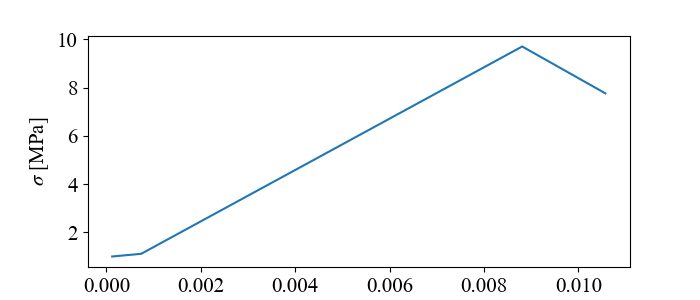

In [465]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(7,3))
fig.canvas.toolbar_position = 'top'
fig.canvas.header_visible = False
ax.set_xlabel(r'$\varepsilon$ [-]'); ax.set_ylabel(r'$\sigma$ [MPa]')

# ax.plot([*eps, 1.15*eps[-1]], [*sig, 0])
# ax.plot([0, eps[3]], [0, E_r * eps[3]], color='black', linewidth=1, linestyle='dashed')

# Generate stress-strain for ATENA
sig_max = sig[1]
sig_norm = sig/sig_max
ax.plot(eps[1:], sig_norm[1:])
eps_atena = eps[1:] - eps[1]
sig_atena = sig_norm[1:]
eps_sig = np.vstack([eps_atena, sig_atena]).T
for eps_i, sig_i in eps_sig:
    print(eps_i, sig_i)

In [466]:
%matplotlib widget
import numpy as np
from bmcs_cross_section.api import ReinfLayer, BarLayer, MKappa, TShape
%matplotlib widget
# %matplotlib qt
from bmcs_cross_section.api import MKappa, TShape, MKappaParamsStudy, EC2, ReinfLayer, IShape, CustomShape
from bmcs_beam.api import BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, LoadDeflectionParamsStudy
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu
mc = MKappa(low_kappa=0, high_kappa=0.0001)
mc.cs_design.cross_section_shape_.trait_set(H=15, B=120)
mc.cs_design.concrete.compression = 'EC2 with plateau'
mc.cs_design.cross_section_shape_.interact()
mc.cs_design.concrete.compression_.trait_set(
    f_c = 68, eps_cy=-0.0035, eps_cu=-0.0038, E_cc=24805
)
A_roving = 1.8
spacing = 12.7 # [mm] 
E_carbon = 1700 # [MPa] 
width = 120 # [mm]
n_rovings = width / spacing
A_layer = n_rovings * A_roving
n_rovings, A_layer

_f_t = 1550
bl1 = ReinfLayer(name='carbon 1', matmod='carbon', z=5, A=A_layer)
bl1.matmod_.trait_set(f_t = _f_t, E=E_carbon)
bl2 = ReinfLayer(name='carbon 2', matmod='carbon', z=3, A=A_layer)
bl2.matmod_.trait_set(f_t = _f_t, E=E_carbon)

mc.cross_section_layout.add_layer(bl1)
mc.cross_section_layout.add_layer(bl2)

mc.high_kappa=0.0002
mc.interact()

in update plot 1e-07


In [467]:
# Reinforcement per unit length per layer
reinf_unit_length = 1000/spacing * A_roving
reinf_unit_length

141.73228346456693

In [468]:
1550/170000

0.009117647058823529

In [469]:
# dp = DeflectionProfile()
# bl1 = ReinfLayer()
# dp.mc.cross_section_layout.add_layer(bl1)
# bl2 = ReinfLayer()
# dp.mc.cross_section_layout.add_layer(bl2)
n_load_steps = 50
dp = DeflectionProfile(mc=mc, n_load_steps = n_load_steps)

dp.beam_design.beam_conf_name = BoundaryConfig.THREE_PB
#dp.beam_design.beam_conf_name.first_load_distance = 1925
dp.beam_design.L = 2000
dp.interact()

In [470]:
import pandas as pd
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib import rcParams
import scipy as sc
import numpy as np
import os
print(os.getcwd())

# Define colors using a list
# Define colors using a list
def plot_multiple_curves(x_list, y_list, color_indices, plot_title, label_list):
    colors = [
        '#00549f',  # 0: dark_blue
        '#407fb7',  # 1: medium_blue
        '#8ebae5',  # 2: light_blue
        '#c7ddf2',  # 3: sky_blue
        '#e8f1fa',  # 4: very_light_blue
        '#57ab27',  # 5: (green)
        '#8dc060',  # 6: (light green)
        '#b8d698',  # 7: (pale green)
        '#ddebce',  # 8: (very pale green)
        '#f2f7ec',   # 9: (almost white)
        '#cc071e',  # 10: (deep red)
        '#d85c41',  # 11: (red orange)
        '#e69679',  # 12: (light red orange)
        '#f3cdbb',  # 13: (pale red orange)
        '#faebe3',  # 14: (very pale red)
        
    ]

    # Set global font to Times New Roman
    rcParams['font.family'] = 'Times New Roman'
    rcParams['mathtext.fontset'] = 'stix'  # Use Times font for math
    rcParams['mathtext.rm'] = 'Times New Roman'  # Set Times for regular math text

    # Set figure size (half A4 width, 8 cm height)
    fig = plt.figure(figsize=(19 / 2.54, 18 / 2.54))  # Convert cm to inches
    # Remove the top and right spines (frames)
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot each curve in the list
    for i in range(len(x_list)):
        plt.plot(x_list[i], y_list[i], label=label_list[i], color=colors[color_indices[i]], linewidth=2)
    
    # Adding labels and legend
    #plt.title(plot_title)
    plt.xlabel('Displacement [mm]', fontsize=22)
    plt.ylabel('Force [kN]', fontsize=22)
    plt.legend(loc='best')
    plt.show()
    
    # size of the labels
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    # size of the legend
    plt.legend(fontsize=22, loc='best', frameon=False)
    
    
    
    # save the plot 
    fig.savefig(plot_title+'.png', dpi=300)
    fig.savefig(plot_title+'.svg', dpi=300)
    fig.savefig(plot_title+'.pdf', dpi=300)
    
    return fig

def get_max_values(x_list, y_list):
    # Initialize lists to store the results
    max_y_values = []
    corresponding_x_values = []
    # Loop through each pair of x and y lists
    for x, y in zip(x_list, y_list):
        max_y = y.max()  # Find the maximum y value
        index_max_y = y.idxmax()  # Find the index of the maximum y value
        corresponding_x = x.loc[index_max_y]  # Retrieve the corresponding x value
        max_y_values.append(max_y)
        corresponding_x_values.append(corresponding_x)
        
    # Display the results as pairs of (max_y, corresponding_x)
    return list(zip(max_y_values, corresponding_x_values))
    

/Users/gui/Documents/VSCode/bmcs_shell/notebooks/folding/geometry/TRR_demonstrator


In [471]:
# Example usage of the function
file_path1 = '/Users/gui/Documents/VSCode/bmcs_shell/notebooks/folding/experiments/FOLD-S-24/WB301.xlsx'
file_path3 = '/Users/gui/Documents/VSCode/bmcs_shell/notebooks/folding/experiments/FOLD-S-24/WB303.xlsx'
file_path4 = '/Users/gui/Documents/VSCode/bmcs_shell/notebooks/folding/experiments/FOLD-S-24/WB304.xlsx'

df_wb1 = pd.read_excel(file_path1)  # Load the first sheet as an example
df_wb3 = pd.read_excel(file_path3)  # Load the first sheet as an example
df_wb4 = pd.read_excel(file_path4)  # Load the first sheet as an example
df_wb1

,Zeit 1 - Langsame Messrate [s],KMD1 [kN],Vorne_links-v-control [mm],Mitte_rechts-v [mm],Vorne_rechts_v [mm],Vorne_rechts_h_0_Grad [mm],Vorne_mitte_h_0_Grad [mm],Zeit 2 - Langsame Messrate [s],Vorne_links_h_0_Grad [mm],Mitte_h_0_Grad_1 [mm],Mitte_h_0_Grad_2 [mm],Mitte_h_90_Grad [mm],Vorne_mitte_h_90_Grad_1 [mm],Vorne_mitte_h_90_Grad_2 [mm],Vorne_v_control [mm],V_Mitte [mm],Kraftges [kN],Zeit [s],Weg_soll []
0,0.0,-0.00232,-0.00211,0.00375,-0.00182,-0.00401,-0.00126,0.0,0.00011,-0.00054,-0.00027,-0.00028,0.00272,-0.00180,0.00051,-0.00180,-0.00621,0.0,-0.2000
1,0.2,-0.00433,-0.00213,0.00374,-0.00184,-0.00398,-0.00126,0.2,0.00000,-0.00054,-0.00027,-0.00029,0.00272,-0.00180,0.00051,-0.00181,-0.00904,0.2,-0.1967
2,0.4,-0.00488,-0.00209,0.00374,-0.00181,-0.00398,-0.00126,0.4,0.00000,-0.00053,-0.00027,-0.00029,0.00272,-0.00180,0.00051,-0.00182,-0.00976,0.4,-0.1933
3,0.6,-0.00566,-0.00209,0.00377,-0.00183,-0.00400,-0.00126,0.6,0.00010,-0.00053,-0.00027,-0.00028,0.00272,-0.00181,0.00051,-0.00183,-0.01085,0.6,-0.1900
4,0.8,-0.00279,-0.00206,0.00381,-0.00183,-0.00400,-0.00126,0.8,0.00010,-0.00054,-0.00027,-0.00028,0.00272,-0.00181,0.00051,-0.00183,-0.00678,0.8,-0.1867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,666.8,30.69000,-4.77700,8.50400,-5.24200,0.15810,0.43690,666.8,-0.84170,0.36580,2.10000,7.32500,2.17500,3.43100,-7.89900,10.90000,36.28000,666.8,10.9100
3335,667.0,30.69000,-4.78600,8.52700,-5.24600,0.15520,0.43710,667.0,-0.84500,0.36330,2.10200,7.33200,2.17800,3.44100,-7.90100,10.90000,36.27000,667.0,10.9200
3336,667.2,30.67000,-4.80400,8.56100,-5.25000,0.14500,0.43730,667.2,-0.84800,0.36080,2.10300,7.33900,2.18000,3.45000,-7.90400,10.91000,36.22000,667.2,10.9200
3337,667.4,30.47000,-4.96000,8.74000,-5.27100,0.10940,0.43750,667.4,-0.85290,0.35790,2.10400,7.34800,2.18500,3.46300,-7.90600,10.91000,35.71000,667.4,10.9200


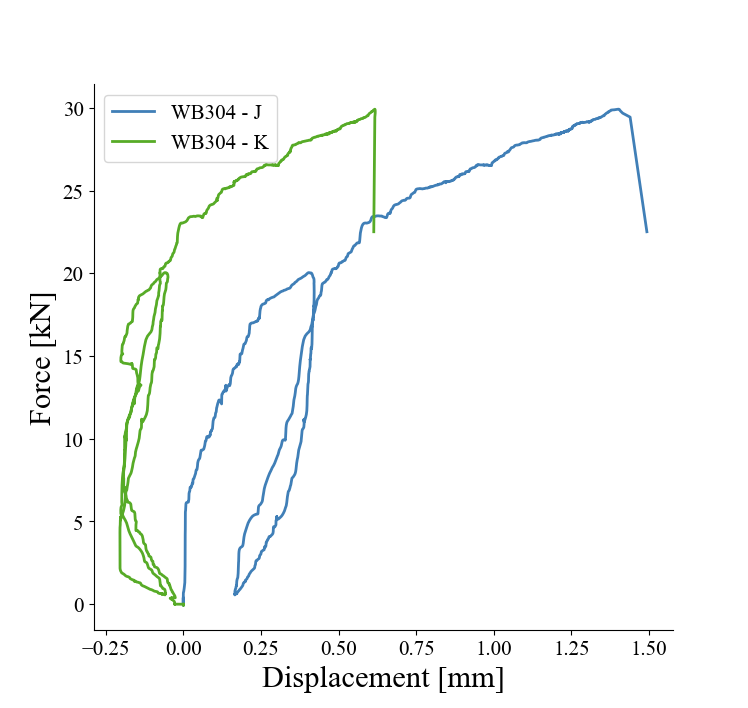

[(np.float64(29.92), np.float64(1.401)),
 (np.float64(29.92), np.float64(0.6166))]

In [472]:
df_jk = pd.read_csv('/Users/gui/Documents/wb-central-point-JK-3.txt', delimiter='\t')
x_jk = df_jk['displacement']
y_jk = df_jk['force']

'''
DISPLACEMENT J-K
'''

# Example data sets
index = 3925
x1 = df_wb1['Mitte_h_0_Grad_1 [mm]'][:index]
y1 = df_wb1['KMD1 [kN]'][:index]

x3 = df_wb3['Mitte_h_0_Grad_1 [mm]'][:index]  # Second set of data (example)
y3 = df_wb3['KMD1 [kN]'][:index]  # Second set of data (example)

x4 = df_wb4['Mitte_h_0_Grad_1 [mm]'][:index]  
y4 = df_wb4['KMD1 [kN]'][:index]  

x11 = df_wb1['Mitte_h_0_Grad_2 [mm]'][:index]
y11 = df_wb1['KMD1 [kN]'][:index]

x33 = df_wb3['Mitte_h_0_Grad_2 [mm]'][:index]  # Second set of data (example)
y33 = df_wb3['KMD1 [kN]'][:index]  # Second set of data (example)

x44 = df_wb4['Mitte_h_0_Grad_2 [mm]'][:index]  
y44 = df_wb4['KMD1 [kN]'][:index]  

# Define the x and y datasets and the corresponding color indices
x_list = [ x4, x44]
y_list = [ y4, y44 ]

# x_list = [ x4, x44]
# y_list = [ y4, y44]

# WB301 = WB1, WB303 = WB2, WB304 = WB3, only for the paper

label_list = ['WB304 - J', 'WB304 - K', 'FE - 3D discrete']  # Labels for each curve
color_indices = [1, 5, 11]  # Color indices for each curve
max_displacement = get_max_values(x_list, y_list)
# Call the plotting function
fig = plot_multiple_curves(x_list, y_list, color_indices, plot_title='FE-JK', label_list=label_list)
max_displacement


In [473]:
max_displacement = np.array(max_displacement, dtype=float)  

force  = max_displacement[:, 0].mean()   # average of the first numbers
disp_jk = max_displacement[:, 1].mean()   # average of the second numbers
         # average of all 12 values (optional)

print("Mean force: kN", force)
print("Mean disp: mm", disp_jk)

K = force / disp_jk
print("Stiffness K: kN/mm", K)

line = 161

K_line = K * 1000/ line
print("Stiffness K per line: N/mm^2 - MPa", K_line)


Mean force: kN 29.92
Mean disp: mm 1.0088
Stiffness K: kN/mm 29.659000793021416
Stiffness K per line: N/mm^2 - MPa 184.21739622994667


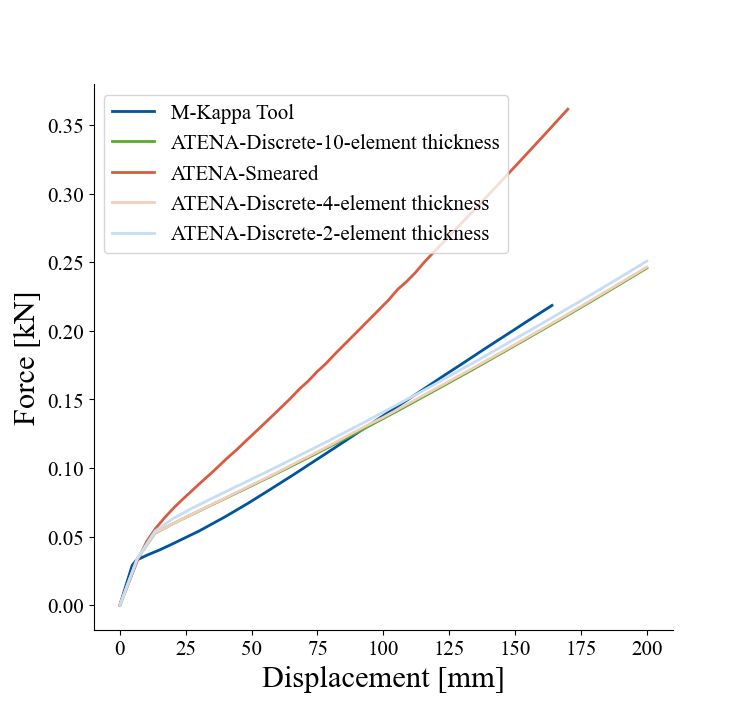

In [474]:

df_mk = pd.read_csv('/Users/gui/Documents/VSCode/cg_fea/3PBT_load_deflection.csv')
df_atena_solid_10 = pd.read_csv('/Users/gui/Documents/3PBT_ATENA_solid.txt', delimiter='\t')
df_atena_solid_4 = pd.read_csv('/Users/gui/Documents/3PBT_ATENA_solid_4.txt', delimiter='\t')
df_atena_smeared = pd.read_csv('/Users/gui/Documents/ATENA-smeared.txt', delimiter='\t')
df_atena_solid_2 = pd.read_csv('/Users/gui/Documents/3PBT_ATENA_solid_2.txt', delimiter='\t')
# Dehnkörperversuche

x1 = df_mk['Deflection [mm]']
y1 = df_mk['Load [kN]']

x2 = df_atena_solid_10['displacement']
y2 = df_atena_solid_10['force']

x3 = df_atena_smeared['displacement']
y3 = df_atena_smeared['force']

x4 = df_atena_solid_4['displacement']
y4 = df_atena_solid_4['force']

x5 = df_atena_solid_2['displacement']
y5 = df_atena_solid_2['force']

# Define the x and y datasets and the corresponding color indices
x_list = [x1, x2, x3, x4, x5]
y_list = [y1, y2, y3, y4, y5]
color_indices = [0, 5, 11, 13, 3]  # Color indices for each curve

label_list = ['M-Kappa Tool', 'ATENA-Discrete-10-element thickness', 'ATENA-Smeared', 'ATENA-Discrete-4-element thickness', 'ATENA-Discrete-2-element thickness'] 
# Call the plotting function
fig = plot_multiple_curves(x_list, y_list, color_indices, plot_title='3PBT', label_list=label_list)

In [475]:
import numpy as np

# Young’s-modulus values in MPa
E_modul = np.array([170, 100, 120, 140, 160, 180, 200, 220, 240, 260],
                   dtype=float)

fnmk = 1200  # σ (or f_nk) in MPa

# ε in mm / m  (= 1000 × dimensionless strain)
eps = fnmk / (E_modul * 1000.0)

print(eps)

[0.00705882 0.012      0.01       0.00857143 0.0075     0.00666667
 0.006      0.00545455 0.005      0.00461538]


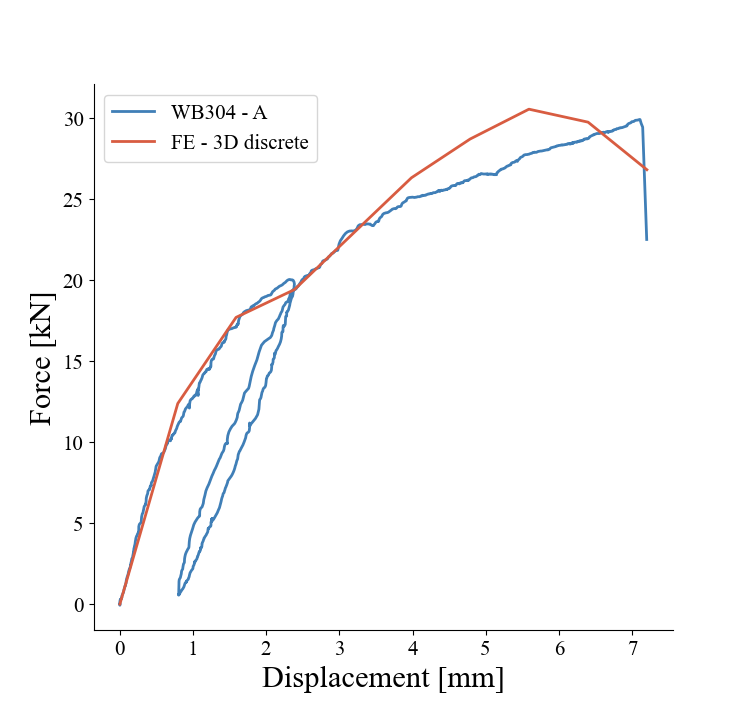

[(np.float64(29.92), np.float64(7.103)),
 (np.float64(30.5532615945592), np.float64(5.59045617426632))]

In [476]:
# df_A = pd.read_csv('/Users/gui/Documents/wb-steg-xy.txt', delimiter='\t')
# x_A = df_A['displacement']
# y_A = df_A['force']


df_steg_fixed = pd.read_csv('/Users/gui/Documents/wb-steg-fixed.txt', delimiter='\t')
df_steg_spring_E100 = pd.read_csv('/Users/gui/Documents/wb-steg-spring-E100.txt', delimiter='\t')
df_steg_spring_E120 = pd.read_csv('/Users/gui/Documents/wb-steg-spring-E120.txt', delimiter='\t')
df_steg_spring_E160 = pd.read_csv('/Users/gui/Documents/wb-steg-spring-E160.txt', delimiter='\t')
df_steg_spring_E170 = pd.read_csv('/Users/gui/Documents/wb-steg-spring-E170.txt', delimiter='\t')
df_steg_fixed_central_E170 = pd.read_csv('/Users/gui/Documents/wb-two-springs-A-3.txt', delimiter='\t')


x_steg_fixed = df_steg_fixed['displacement']
y_steg_fixed = df_steg_fixed['force']

x_steg_spring_E100 = df_steg_spring_E100['displacement']
y_steg_spring_E100 = df_steg_spring_E100['force']

x_steg_spring_E120 = df_steg_spring_E120['displacement']
y_steg_spring_E120 = df_steg_spring_E120['force']

x_steg_spring_E160 = df_steg_spring_E160['displacement']
y_steg_spring_E160 = df_steg_spring_E160['force']

x_steg_spring_E170 = df_steg_spring_E170['displacement']
y_steg_spring_E170 = df_steg_spring_E170['force']

x_steg_fixed_central_E170 = df_steg_fixed_central_E170['displacement'][:-6]
y_steg_fixed_central_E170 = df_steg_fixed_central_E170['force'][:-6]


'''
EXPERIMENTELL DISPLACEMENT V_MITTE - A
'''
# Example data sets
index = 4000
x1 = df_wb1['V_Mitte [mm]'][:index]
y1 = df_wb1['KMD1 [kN]'][:index]

x3 = df_wb3['V_Mitte [mm]'][:index]  # Second set of data (example)
y3 = df_wb3['KMD1 [kN]'][:index]  # Second set of data (example)

x4 = df_wb4['V_Mitte [mm]'][:index]  
y4 = df_wb4['KMD1 [kN]'][:index]  

# Define the x and y datasets and the corresponding color indices
x_list = [ x4, x_steg_fixed_central_E170]
y_list = [y4,y_steg_fixed_central_E170]


# WB301 = WB1, WB303 = WB2, WB304 = WB3, only for the paper

label_list = ['WB304 - A',  'FE - 3D discrete']  # Labels for each curve
color_indices = [1, 11]  # Color indices for each curve
max_displacement = get_max_values(x_list, y_list)
# Call the plotting function
fig = plot_multiple_curves(x_list, y_list, color_indices, plot_title='FE - 3D discrete ', label_list=label_list)
max_displacement

In [477]:
1500/123880

0.012108492089118501

In [478]:
# define the variables a, b, c, e, \gamma in sympy 
a, b, c, e, gamma, t, rho = sp.symbols('a b c e gamma t rho')

In [479]:
Lx = 2*(a + 2*e + c) 
Ly = 2*b

In [480]:
Lx

2*a + 2*c + 4*e

In [481]:
Ly

2*b

In [482]:
A = Lx * Ly
A

2*b*(2*a + 2*c + 4*e)

In [483]:
V_total = A * t
V_total

2*b*t*(2*a + 2*c + 4*e)

In [484]:
1150/123880

0.009283177268324184